# Using the simulations for 3D computations

 xroms for buoyancy computations, and spectral analysis with xrft, however cospectra from xrft and interpolation from xroms seem to be in conflict. There are two enviroments (XROMS and ROMS)

In [ ]:
# import xesmf as xe
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter

import xroms
import numpy as np
import seawater as sw
from dask.diagnostics import ProgressBar
import scipy.integrate as integ


import sys
sys.path.append("/homes/metogra/iufarias/Documents/Scripts/useful")
import romspickle as rp

from dask.diagnostics import ProgressBar
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})


plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [2]:
def spec_ogive(spec,kr):
    
    Ogive_Kr=np.array(kr)
    # Middle Value Wavenumber position for plot
    Ogive_Krx=(Ogive_Kr[:-1]+Ogive_Kr[1:])/2
    # dK=np.diff(Ogive_Kr)[0]
    
    #Flipped Integration in wavenumber and then flipped again
    Ogive_inv=integ.cumtrapz(y=spec[::-1],x=Ogive_Kr[::-1]);
    Ogive_Spec=-Ogive_inv[::-1];


    return Ogive_Krx,Ogive_Spec

def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og


In [3]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
# client=dask.distributed.Client()
# client

In [6]:

def calc_MLD(dens_int,fillna=2e20,thresh=0.125,coo='z_rho'):
    '''
    dens_int: Interpolated density xarray (from xroms.isoslice)
    '''
    if coo in dens_int.dims:            
        dens_int_new=dens_int.dropna(coo)
        zdic={'{0}'.format(coo):0}
        mld_dens = dens_int_new.isel(zdic)  + thresh
        
        z_indexes = (abs(dens_int_new - mld_dens)).fillna(fillna).argmin(coo)
        mld_f = dens_int_new[coo][z_indexes]
    else:
        print('z_rho dimension not found')
    
    return mld_f

In [7]:
# chunks={'time_counter':10, 'x_rho':1000, 'y_rho':1520,'s_rho':40,'s_w':40}

#3D
path='/data/pacific/lrenault/SASI/CROCO/'

# path='/data/pacific/lrenault/SASI/CROCO/'
# listF=glob(path+'FULL/SASI*2012*.nc');listF.sort()
# listT=glob(path+'SMTH/SASI*2012*.nc');listT.sort()

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal')
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal')



In [8]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

### KE Spectra Calculation

In [10]:
dec=50
c_dec=6

In [11]:
# chunks_vel={'ocean_time':1,'s_rho':1}
chunks_vel={'ocean_time':1,'s_rho':1}

In [12]:
%%time
with ProgressBar():
    uf=df.u.xroms.to_grid('psi', 's_rho')#.resample(ocean_time='1D').mean()#.groupby("ocean_time.dayofyear").mean()
    vf=df.v.xroms.to_grid('psi', 's_rho')#.resample(ocean_time='1D').mean()#.groupby("ocean_time.dayofyear").mean()
    
    ut=dt.u.xroms.to_grid('psi', 's_rho')#.resample(ocean_time='1D').mean()#.groupby("ocean_time.dayofyear").mean()
    vt=dt.v.xroms.to_grid('psi', 's_rho')#.resample(ocean_time='1D').mean()#.groupby("ocean_time.dayofyear").mean()

CPU times: user 122 ms, sys: 130 µs, total: 123 ms
Wall time: 121 ms


In [47]:
%time
with ProgressBar():
    uf=uf[::4,55:,120:-120,120:800]
    vf=vf[::4,55:,120:-120,120:800]
    
    ut=ut[::4,55:,120:-120,120:800]
    vt=vt[::4,55:,120:-120,120:800]

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 16.7 µs


In [48]:
%time
with ProgressBar():
    uf=uf.compute()
    vf=vf.compute()
    
    ut=ut.compute()
    vt=vt.compute()

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 11.4 µs
[#####                                   ] | 12% Completed | 392.04 s


KeyboardInterrupt: 

In [27]:
with ProgressBar():
    uff=df.u.xroms.to_grid('psi', 's_rho')[0,:,120:-120,120:800].compute()
    # uff.xroms.isoslice(np.linspace(-5,-100, 10))

[########################################] | 100% Completed | 297.38 s


In [28]:
ufi=uff.xroms.isoslice(np.linspace(-5,-100, 10))

In [33]:
zz=df.u.z_rho_u[0,:,120:-120,120:800].compute()

(-200.0, 0.0)

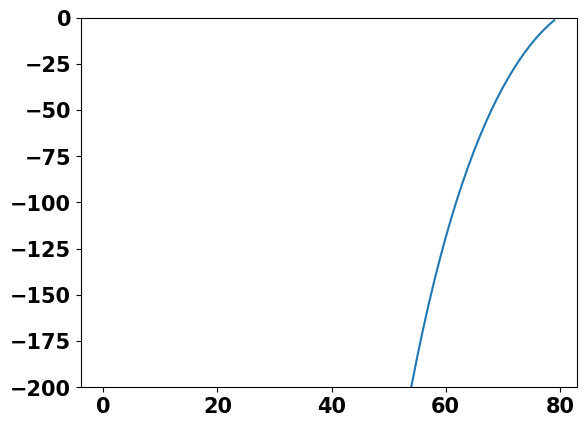

In [38]:
plt.plot(zz.mean(axis=1).mean(axis=1))
plt.ylim(-200,0)

In [19]:
with ProgressBar():
    ufi=uf.xroms.isoslice(np.linspace(-5,-100, 10))
    vfi=vf.xroms.isoslice(np.linspace(-5,-100, 10))
    uti=ut.xroms.isoslice(np.linspace(-5,-100, 10))
    vti=vt.xroms.isoslice(np.linspace(-5,-100, 10))

IndexError: list index out of range

In [ ]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(ufi.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    Vf=xrft.isotropic_power_spectrum(vfi.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    Ut=xrft.isotropic_power_spectrum(uti.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    Vt=xrft.isotropic_power_spectrum(vti.drop(['z_rho_psi']),
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)



In [105]:
# Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))
# Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))

# KEf=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'z_rho_psi':Uf.z_rho_psi,'freq_r':Uf.freq_r.data}))
# KEt=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'z_rho_psi':Uf.z_rho_psi,'freq_r':Uf.freq_r.data}))


KEf=xr.DataArray(data=0.5*(Uf.data + Vf.data),
                 coords=({'ocean_time':Uf.ocean_time.data,'z_rho_psi':Uf.z_rho_psi.data,'freq_r':Uf.freq_r.data}))
KEt=xr.DataArray(data=0.5*(Ut.data + Vt.data),
                 coords=({'ocean_time':Ut.ocean_time.data,'z_rho_psi':Uf.z_rho_psi.data,'freq_r':Uf.freq_r.data}))

In [106]:
KEf_sum=KEf.sum('z_rho_psi')
KEt_sum=KEt.sum('z_rho_psi')

In [30]:
dxx=0.5

## Plotting Averaged Spectrum

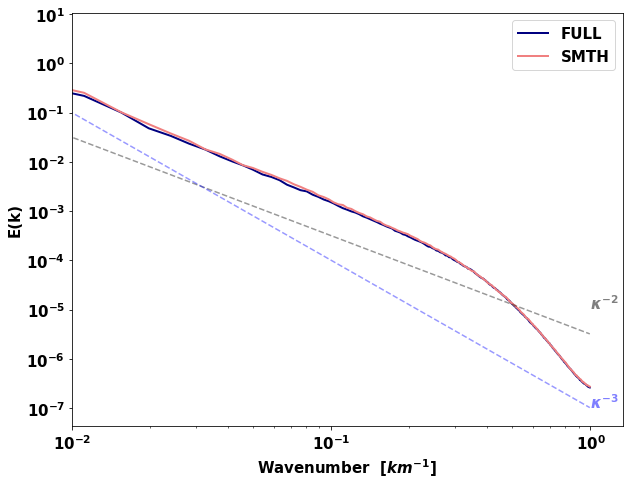

In [108]:

plt.figure(figsize=(9,7))

plt.plot(KEf_sum.freq_r/dxx,KEf_sum.mean('ocean_time'),label='FULL',linewidth=2,color='navy')
plt.plot(KEt_sum.freq_r/dxx,KEt_sum.mean('ocean_time'),label='SMTH',linewidth=2,color='lightcoral')

# plt.plot([1/50,1/50],[1000,0],'k--')


k2 = np.array([KEf_sum.freq_r[0],KEf_sum.freq_r[-1]])/dxx
E2 = (1/k2)**2/(10**5.5)

k3 = np.array([KEf_sum.freq_r[0],KEf_sum.freq_r[-1]])/dxx
E3 = (1/k3)**3/(10**7)

# k53 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
# E53 = (1/k53)**(5/3)/(10**5)

plt.plot(k2,E2,'k--',alpha=0.4)
plt.text(1,1e-5,r'$\kappa^{-2}$',weight='normal',alpha=0.5)

plt.plot(k3,E3,'b--',alpha=0.4)
plt.text(1,1e-7,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.5)



plt.legend()

plt.yscale('symlog',linthreshy=1e-11)
plt.xscale('log')



# plt.title('EKE')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(1/100,0)
# plt.ylim(-1e-11,1e-8)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/z_integ_Total_avg_KE.png')

## Ogive graphs

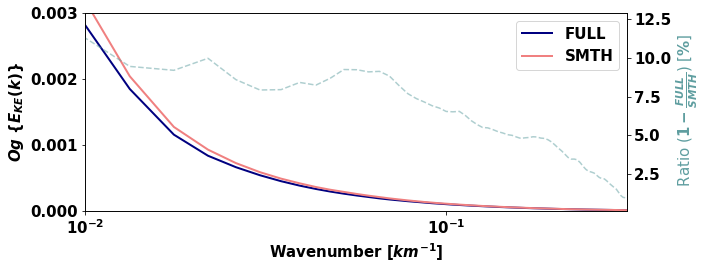

In [109]:
'Ogive graph - Backwards'


Kf=KEf_sum.mean('ocean_time')
Kt=KEt_sum.mean('ocean_time')

# Kf=KEf_sum
# Kt=KEt_sum

Kk=np.array(KEf_sum.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

KAf=-KAf[::-1]
KAt=-KAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),KAf,label='FULL',linewidth=2,color='navy')
ax.plot((np.log10(Kx)),KAt,label='SMTH',linewidth=2,color='lightcoral')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
ax.set_ylim(-1e-5,3e-3)



ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-(KAf)/(KAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/z_integ_Ogive_avg_KE.png')

# Layered Analysis

In [26]:
chunks_i={'s_rho':1}

In [236]:
# i=400
for i in np.arange(0,728,20):

    ufi=df.u.xroms.to_grid('psi', 's_rho')[i,-20:,200:-200,100:750];ufi=ufi.chunk(chunks=chunks_i).compute()
    vfi=df.v.xroms.to_grid('psi', 's_rho')[i,-20:,200:-200,100:750];vfi=vfi.chunk(chunks=chunks_i).compute()

    uti=dt.u.xroms.to_grid('psi', 's_rho')[i,-20:,200:-200,100:750];uti=uti.chunk(chunks=chunks_i).compute()
    vti=dt.v.xroms.to_grid('psi', 's_rho')[i,-20:,200:-200,100:750];vti=vti.chunk(chunks=chunks_i).compute()


    ufx=ufi.xroms.isoslice(np.linspace(-5,-100, 50))
    vfx=vfi.xroms.isoslice(np.linspace(-5,-100, 50))
    utx=uti.xroms.isoslice(np.linspace(-5,-100, 50))
    vtx=vti.xroms.isoslice(np.linspace(-5,-100, 50))


    Ufi=xrft.isotropic_power_spectrum(ufx[:-15,:,:610],
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', 
                                      window=True).expand_dims(dim='ocean_time')
    Vfi=xrft.isotropic_power_spectrum(vfx[:-15,:,:610],
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', 
                                      window=True).expand_dims(dim='ocean_time')
    Uti=xrft.isotropic_power_spectrum(utx[:-15,:,:610],
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', 
                                      window=True).expand_dims(dim='ocean_time')
    Vti=xrft.isotropic_power_spectrum(vtx[:-15,:,:610],
                                     dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', 
                                      window=True).expand_dims(dim='ocean_time')

    KEfi=xr.DataArray(data=0.5*(Ufi.data + Vfi.data),
                     coords=({'ocean_time':Ufi['ocean_time'],'z_rho_psi':Ufi.z_rho_psi.data,'freq_r':Ufi.freq_r.data}))
    KEti=xr.DataArray(data=0.5*(Uti.data + Vti.data),
                     coords=({'ocean_time':Uti['ocean_time'],'z_rho_psi':Uti.z_rho_psi.data,'freq_r':Uti.freq_r.data}))

    KEfi.to_netcdf('/homes/metogra/iufarias/Documents/data/spec/KE/full_{0}_KE_z_spec.nc'.format(i),mode='w')
    KEti.to_netcdf('/homes/metogra/iufarias/Documents/data/spec/KE/smth_{0}_KE_z_spec.nc'.format(i),mode='w')


In [134]:
# with ProgressBar():
    # Ufi=xrft.isotropic_power_spectrum(ufx[:-15,:,:610].drop(['z_rho_psi']),
    #                                  dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    # Vfi=xrft.isotropic_power_spectrum(vfx[:-15,:,:610].drop(['z_rho_psi']),
    #                                  dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    # Uti=xrft.isotropic_power_spectrum(utx[:-15,:,:610].drop(['z_rho_psi']),
    #                                  dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    # Vti=xrft.isotropic_power_spectrum(vtx[:-15,:,:610].drop(['z_rho_psi']),
    #                                  dim=['xi_u','eta_v'],nfactor=2,truncate='True',detrend='linear', window=True)



In [171]:
# KEfi=xr.DataArray(data=0.5*(Ufi.data + Vfi.data),
#                  coords=({'z_rho_psi':Ufi.z_rho_psi.data,'freq_r':Ufi.freq_r.data}))
# KEti=xr.DataArray(data=0.5*(Uti.data + Vti.data),
#                  coords=({'z_rho_psi':Ufi.z_rho_psi.data,'freq_r':Ufi.freq_r.data}))

In [172]:
# KEfi.to_netcdf('/homes/metogra/iufarias/Documents/data/spec/KE/full_{0}_KE_z_spec.nc'.format(i),mode='w')
# KEti.to_netcdf('/homes/metogra/iufarias/Documents/data/spec/KE/smth_{0}_KE_z_spec.nc'.format(i),mode='w')

In [237]:
KE_fi=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/spec/KE/full_*.nc',combine_attrs='override',data_vars='minimal')
KE_ti=xr.open_mfdataset('/homes/metogra/iufarias/Documents/data/spec/KE/smth_*.nc',combine_attrs='override',data_vars='minimal')


# KEfi=aa['__xarray_dataarray_variable__']

In [267]:
KEfi=KE_fi.__xarray_dataarray_variable__.mean(axis=0)
KEti=KE_ti.__xarray_dataarray_variable__.mean(axis=0)

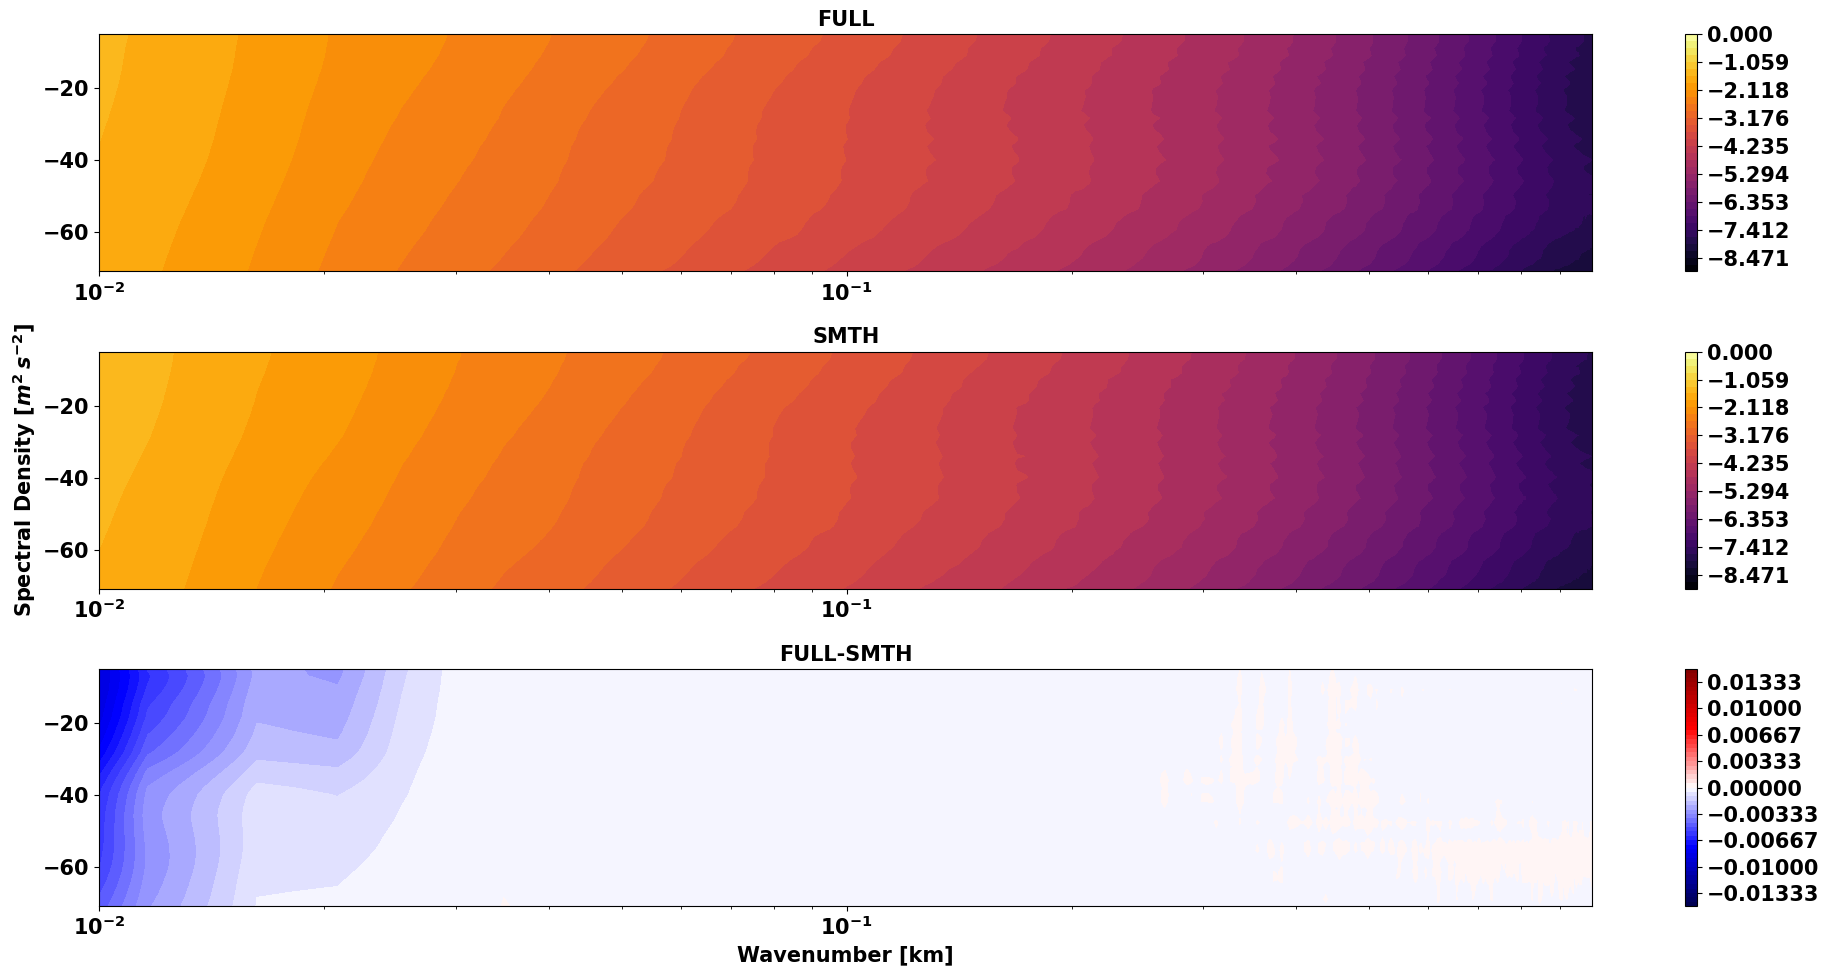

In [270]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.contourf(KEfi.freq_r/dxx,KEfi.z_rho_psi,np.log10(KEfi),levels=np.linspace(-9,0,35),cmap='inferno')
plt.title('FULL',fontsize=15,fontweight='bold')
plt.xscale('log')
plt.xlim(1/100,0)

plt.colorbar()

plt.subplot(3,1,2)
plt.contourf(KEti.freq_r/dxx,KEti.z_rho_psi,np.log10(KEti),levels=np.linspace(-9,0,35),cmap='inferno')
plt.title('SMTH',fontsize=15,fontweight='bold')


plt.xscale('log')
plt.xlim(1/100,0)


plt.ylabel(r'Spectral Density [$m^{2}\,s^{-2}$]',fontsize=15,fontweight='bold')
plt.colorbar()

plt.subplot(3,1,3)
plt.contourf(KEfi.freq_r/dxx,KEfi.z_rho_psi,(KEfi-KEti),levels=np.linspace(-0.015,0.015,55),cmap='seismic')
plt.title('FULL-SMTH',fontsize=15,fontweight='bold')


plt.colorbar()
plt.xscale('log')
plt.xlim(1/100,0)


plt.xlabel('Wavenumber [km]',fontsize=15,fontweight='bold')

plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_zintegrated/2D_z_avg_KE.png')

## VBP

In [9]:
dec=50
c_dec=int(df.u.shape[0]/dec)

In [10]:
# chunks_rho={'ocean_time':1,'s_rho':1}
chunks_rho={'ocean_time':c_dec,'s_rho':1}

In [16]:
with ProgressBar():
    tf=df.temp.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];tf=tf.chunk(chunks=chunks_rho).compute()
    sf=df.salt.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];sf=sf.chunk(chunks=chunks_rho).compute()
    
    tt=dt.temp.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];tt=tt.chunk(chunks=chunks_rho).compute()
    st=dt.salt.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];st=st.chunk(chunks=chunks_rho).compute()

[                                        ] | 1% Completed | 106.99 ss


KeyboardInterrupt: 

In [ ]:
with ProgressBar():
    rhof=xroms.potential_density(tf,sf)
    rhot=xroms.potential_density(tt,st)



In [135]:
with ProgressBar():
    bf=xroms.buoyancy(rhof)
    bt=xroms.buoyancy(rhot)
    

In [188]:
with ProgressBar():
    wf=df.w.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];wf=wf.chunk(chunks=chunks_rho).compute()
    wt=dt.w.xroms.to_grid('psi', 's_rho')[0::50,:,200:-200,100:750];wt=wt.chunk(chunks=chunks_rho).compute()

[########################################] | 100% Completed | 14min 25.1s
[########################################] | 100% Completed | 14min  9.7s


In [11]:
with ProgressBar():
    bfi=bf.xroms.isoslice(np.linspace(-5,-100, 10))
    wfi=wf.xroms.isoslice(np.linspace(-5,-100, 10))
    bti=bt.xroms.isoslice(np.linspace(-5,-100, 10))
    wti=wt.xroms.isoslice(np.linspace(-5,-100, 10))

NameError: name 'bf' is not defined

In [12]:
del bfi.attrs['grid']
del wfi.attrs['grid']
del bti.attrs['grid']
del wti.attrs['grid']

NameError: name 'bfi' is not defined

In [200]:
# bfi.to_netcdf("/homes/metogra/iufarias/Documents/data/bfi.nc")
# bti.to_netcdf("/homes/metogra/iufarias/Documents/data/bti.nc")
# wfi.to_netcdf("/homes/metogra/iufarias/Documents/data/wfi.nc")
# wti.to_netcdf("/homes/metogra/iufarias/Documents/data/wti.nc")

In [9]:

bfi=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/bfi.nc")
bti=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/bti.nc")
wfi=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/wfi.nc")
wti=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/wti.nc")

In [10]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'



VBP_f=xrft.isotropic_cross_spectrum(wfi.drop(['z_rho_psi']),
                                bfi.drop(['z_rho_psi']),
                                         dim=['xi_u','eta_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

VBP_t=xrft.isotropic_cross_spectrum(wti.drop(['z_rho_psi']),
                                bti.drop(['z_rho_psi']),
                                         dim=['xi_u','eta_v'],nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

In [11]:
# VBP_f_zavg=VBP_f.sum('z_rho_psi')/10
# VBP_t_zavg=VBP_t.sum('z_rho_psi')/10


VBP_f_zint=VBP_f.sum('z_rho_psi')*10
VBP_t_zint=VBP_t.sum('z_rho_psi')*10

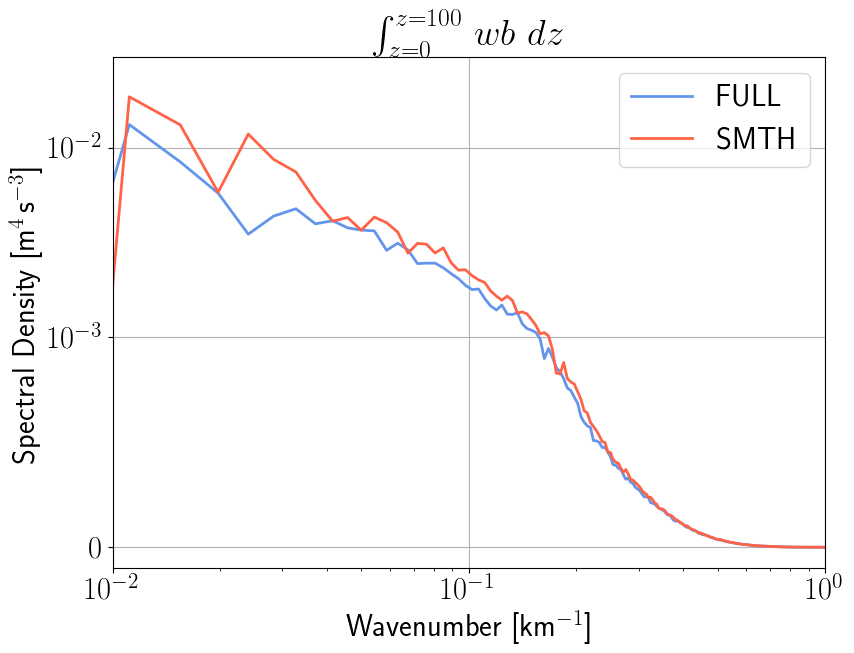

In [14]:
plt.figure(figsize=(9,7))



plt.plot(VBP_f_zint.freq_r/dxx,VBP_f_zint.mean('ocean_time')/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(VBP_t_zint.freq_r/dxx,VBP_t_zint.mean('ocean_time')/dxx*1e3,label='SMTH',linewidth=2,color='tomato')


plt.legend()

plt.yscale('symlog',linthresh=1e-3)
# plt.yscale('log')
plt.xscale('log')

plt.title(r'$\int^{z=100}_{z=0}$ $wb$ $dz$',fontweight='bold')
plt.ylabel(r'Spectral Density [m$^4\,$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.grid()



plt.xlim(1/100,1)
plt.ylim(-1e-4,0.3e-1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/total_avg/Total_avg_100m_int_VBP.png')

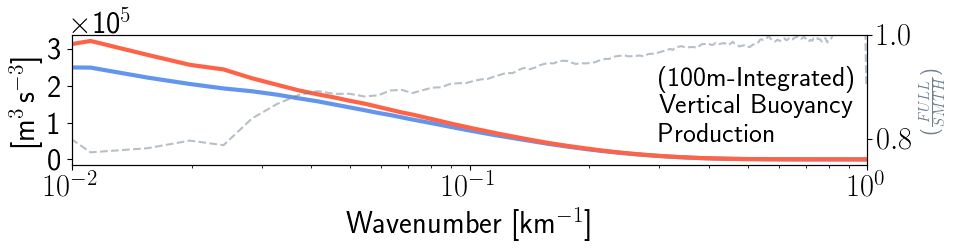

In [55]:

Kf=VBP_f_zint.mean('ocean_time')/dxx*1e3
Kt=VBP_t_zint.mean('ocean_time')/dxx*1e3


# Kx,KAf=spec_ogive(spec=Kf,kr=Kf.freq_r/dxx)
# _,KAt=spec_ogive(spec=Kt,kr=Kt.freq_r/dxx)

KAf=ogive(Kf.freq_r/dxx*1e3,Kf/dxx*1e3) #in metersss
Kx=Kf.freq_r/dxx #in Kilometers
KAt=ogive(Kt.freq_r/dxx*1e3,Kt/dxx*1e3)#in metersss






fig,ax = plt.subplots(figsize=(10,3))
ax.plot(Kx,KAf,label='FULL',linewidth=3,color='cornflowerblue')
ax.plot(Kx,KAt,label='SMTH',linewidth=3,color='tomato')
# ax.set_title(r'$\int^{z=100}_{z=0}$ $wb$ $dz$',fontweight='bold')


ax.set_xscale('log')

ax.set_xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'[m$^3\,$s$^{-3}$]',fontweight='bold')
ax.set_xlim(1e-2,1)
# ax.set_ylim(-1e-11,4e-11)

yticks=np.arange(KAt.min(),KAt.max(),1e5)
yticklabel=np.int_(yticks/1e5)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabel)

plt.text(1e-2,(yticks[-1]+0.5e5),r'$\times$10$^{5}$')
ax.text(3e-1,2e5,r'(100m-Integrated)',fontsize=20)
ax.text(3e-1,1.3e5,r'Vertical Buoyancy ',fontsize=20)
ax.text(3e-1,0.5e5,r'Production',fontsize=20)

# ax.yaxis.set_major_formatter(FormatStrFormatter('%.e'))

                             
# ax.legend()

ax2=ax.twinx()
ax2.plot((Kx),((KAf)/(KAt)),alpha=0.5,linestyle='dashed',color='slategrey')
ax2.set_ylabel(r'($\frac{FULL}{SMTH}$)',fontsize=15,color='slategrey')
ax2.set_xscale('log')
ax2.set_ylim(0.75,1)
plt.tight_layout()


plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/ogives/Ogive_avg_100m_int_VBP.png')


In [19]:
%%time
tf=df.temp.groupby("ocean_time.dayofyear").mean();
tf=tf.chunk(chunks=chunks_rho)
tf=tf[:,-15:-1,300:-300,90:700]
tf=tf.chunk(chunks=chunks_rho)


sf=df.salt.groupby("ocean_time.dayofyear").mean();
sf=sf.chunk(chunks=chunks_rho)
sf=sf[:,-15:-1,300:-300,90:700]
sf=sf.chunk(chunks=chunks_rho)

CPU times: user 631 ms, sys: 5.45 ms, total: 636 ms
Wall time: 631 ms


In [9]:
%%time

rhof=xroms.potential_density(tf,sf)
bf=xroms.buoyancy(rhof)

CPU times: user 742 ms, sys: 2.75 ms, total: 745 ms
Wall time: 746 ms


In [10]:
%%time

tt=dt.temp.groupby("ocean_time.dayofyear").mean();
tt=tf.chunk(chunks=chunks_rho)
tt=tt[:,-15:-1,300:-300,90:700]
tt=tt.chunk(chunks=chunks_rho)


st=dt.salt.groupby("ocean_time.dayofyear").mean();
st=sf.chunk(chunks=chunks_rho)
st=st[:,-15:-1,300:-300,90:700]
st=st.chunk(chunks=chunks_rho)


CPU times: user 1.25 s, sys: 7.52 ms, total: 1.25 s
Wall time: 1.25 s


In [11]:
%%time
rhot=xroms.potential_density(tt,st)
bt=xroms.buoyancy(rhot)

CPU times: user 756 ms, sys: 68 µs, total: 756 ms
Wall time: 755 ms


In [12]:
%%time 
wf=df.w.groupby("ocean_time.dayofyear").mean();
# wf=df.w.groupby("ocean_time.month").mean();
# wf=wf.isel(s_rho=range(-15,-1),xi_rho=range(800));
# wf=wf.isel(eta_rho=range(100,1300));
# wf=wf.chunk(chunks=chunks_rho)

wf=wf[:,-15:-1,300:-300,90:700]
wf=wf.chunk(chunks=chunks_rho)




CPU times: user 628 ms, sys: 4.58 ms, total: 632 ms
Wall time: 628 ms


In [13]:
%%time
wt=dt.w.groupby("ocean_time.dayofyear").mean();
# wt=dt.w.groupby("ocean_time.month").mean();
# wt=wt.isel(s_rho=range(-15,-1),xi_rho=range(800));
# wt=wt.isel(eta_rho=range(100,1300));
# wt=wt.chunk(chunks=chunks_rho)

wt=wt[:,-15:-1,300:-300,90:700]
wt=wt.chunk(chunks=chunks_rho)



CPU times: user 703 ms, sys: 5.06 ms, total: 709 ms
Wall time: 704 ms


In [14]:
Bfi=bf.sum(axis=1)
Bti=bt.sum(axis=1)
Wfi=wf.sum(axis=1)
Wti=wt.sum(axis=1)

In [48]:
%%time
with ProgressBar():
    VBPf=xrft.isotropic_cross_spectrum(Wfi[:,:,:].drop(['nav_lat_rho', 'nav_lon_rho']).compute(),
                                       Bfi[:,:,:].drop(['nav_lat_rho', 'nav_lon_rho']).compute(),dim=['xi_rho','eta_rho'],nfactor=2,truncate='True',detrend='linear', window=True)

[########################################] | 100% Completed | 30min 58.0s
[########################################] | 100% Completed |  1hr  0min  8.6s
CPU times: user 45min 59s, sys: 1h 34min 36s, total: 2h 20min 35s
Wall time: 1h 31min 27s


In [50]:
VBPf.real.to_netcdf("/homes/metogra/iufarias/Documents/data/VBPf.nc")

In [19]:
%%time
with ProgressBar():
    VBPt=xrft.isotropic_cross_spectrum(dd.drop(['nav_lat_rho', 'nav_lon_rho']),
                                       cc.drop(['nav_lat_rho', 'nav_lon_rho']),dim=['xi_rho','eta_rho'],nfactor=2,truncate='True',detrend='linear', window=True)

CPU times: user 3min 8s, sys: 8min 30s, total: 11min 39s
Wall time: 14.2 s


In [20]:
VBPt.real.to_netcdf("/homes/metogra/iufarias/Documents/data/VBPt.nc")

In [12]:
VBPt=xr.DataArray("/homes/metogra/iufarias/Documents/data/VBPt.nc")
VBPf=xr.DataArray("/homes/metogra/iufarias/Documents/data/VBPf.nc")

In [22]:
from netCDF4 import Dataset
VBPf=Dataset("/homes/metogra/iufarias/Documents/data/VBPf.nc")
VBPt=Dataset("/homes/metogra/iufarias/Documents/data/VBPt.nc")

In [24]:
VBPt['__xarray_dataarray_variable__'][:].shape

(214, 2)